## Preprocessing nuclei segmentation training datasets for Inception-V3

First let's load all of the python packages that we will need.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import morphology as morph
import scipy as sp
from scipy import ndimage
from skimage import feature
from skimage import exposure, io
from skimage.io import imread, imsave
from utils import get_image
import glob, os, fnmatch

Using TensorFlow backend.


We define the directories where the images and classes are located. We define both training and validation datasets.

In [2]:
# Confocal
direc_name = './trainingData/nucleiSegmentation/'
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_CF_IncV3.npz')
training_direcs = ["E2F3A_E2F8_mouse1_image1","E2F3A_E2F8_mouse1_image2","E2F3A_E2F8_mouse1_image3","E2F3A_EdU_mouse1_image1","E2F3A_EdU_mouse1_image2","E2F3A_EdU_mouse1_image4","E2F3A_pH3_mouse1_image1","E2F3A_pH3_mouse1_image2","E2F3A_pH3_mouse1_image3","E2F8_EdU_mouse1_image1","E2F8_EdU_mouse1_image2","E2F8_pH3_mouse1_image2"]

channel_names = ["nuclear"]

We define the parameteres for preprocessing.

In [3]:
# half window size for imaging field
window_size_x = 32
window_size_y = 32
# number of classes
nb_classes = 3
# maximum number of training cases
max_training_examples = 10000000
# parameter used to dilate one class (here the nuclei contours)
is_edge_class = [1,0,0]
# structuring element size for dilation
dil_radius = 1

We load the images and initialize the variables.

In [4]:
nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variables for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

We preprocess the images and classes: <br>
    1) the intensity in the images is dividied by themedian intensity <br>
    2) a local average subtraction is applied <br>
    3) a dilation is applied to the nuclei contours

In [5]:
# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter,:,:,channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter,:,:,j] = class_img
       
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter,:,:,j] -= class_mask[direc_counter,:,:,k]
			class_mask[direc_counter,:,:,j] = class_mask[direc_counter,:,:,j] > 0

	direc_counter += 1

We plot the first 3 images and classes to make sure everything went well.

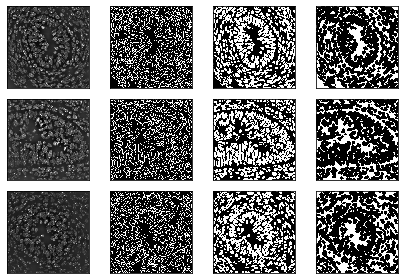

In [6]:
nb_training_examples = 3#len(training_direcs)
fig,ax = plt.subplots(nb_training_examples,nb_classes+1, squeeze = False)
for j in range(nb_training_examples):
	ax[j,0].imshow(channels[j,:,:,0],cmap=plt.cm.gray,interpolation='nearest')
	def form_coord(x,y):
		return cf(x,y,channels[j,:,:,0])
	ax[j,0].format_coord = form_coord
	ax[j,0].axes.get_xaxis().set_visible(False)
	ax[j,0].axes.get_yaxis().set_visible(False)

	for k in range(1,nb_classes+1):
		ax[j,k].imshow(class_mask[j,:,:,k-1],cmap=plt.cm.gray,interpolation='nearest')
		def form_coord(x,y):
			return cf(x,y,class_mask[j,:,:,k-1])
		ax[j,k].format_coord = form_coord
		ax[j,k].axes.get_xaxis().set_visible(False)
		ax[j,k].axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

We want to equally sample each individual class by considering for each image the minimum number of pixels corresponding to one class as the number of training examples. We estimate that number for each image.

In [7]:
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
	min_pixel_counter[j] = np.Inf
	nb_pixels_class = 0
	for k in range(nb_classes):
		nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
		if nb_pixels_class < min_pixel_counter[j]:
			min_pixel_counter[j] = nb_pixels_class

We equally sample each individual class for each image.

In [8]:
for direc in range(channels.shape[0]):

	for k in range(nb_classes):
		class_counter = 0
		class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

		if len(class_rows_temp) > 0:

			# Randomly permute index vector
			non_rand_ind = np.arange(len(class_rows_temp))
			rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

			for i in rand_ind:
				if class_counter < min_pixel_counter[direc]:
					if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
						if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
							class_rows += [class_rows_temp[i]]
							class_cols += [class_cols_temp[i]]
							class_batch += [direc]
							class_label += [k]
							class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

We randomly shuffle the order of the training examples and make sure the number of training examples is inferior to the defined cap.

In [9]:
# Randomly select training points 
if len(class_rows) > max_training_examples:
	non_rand_ind = np.arange(len(class_rows))
	rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

	class_rows = class_rows[rand_ind]
	class_cols = class_cols[rand_ind]
	class_batch = class_batch[rand_ind]
	class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

We save the preprocessed training dataset.

In [10]:
np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

We do the same for wide-field images...

In [11]:
# WideField
direc_name = './trainingData/nucleiSegmentation/'
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_WF_IncV3.npz')
training_direcs = ["E2F3A_E2F4_mouse1_image1","E2F3A_E2F4_mouse1_image2","E2F3A_E2F4_mouse1_image3","E2F3A_E2F4_mouse2_image1","E2F3A_E2F4_mouse2_image2","E2F3A_E2F4_mouse2_image3","E2F3A_E2F8_mouse2_image1","E2F3A_E2F8_mouse2_image2","E2F3A_E2F8_mouse3_image1","E2F3A_E2F8_mouse3_image2","E2F3A_E2F8_mouse3_image3","E2F3A_EdU_mouse2_image1","E2F3A_EdU_mouse2_image2","E2F3A_EdU_mouse2_image3","E2F3A_EdU_mouse3_image1","E2F3A_EdU_mouse3_image2","E2F3A_pH3_mouse2_image1","E2F3A_pH3_mouse2_image2","E2F3A_pH3_mouse2_image3","E2F3A_pH3_mouse3_image1","E2F3A_pH3_mouse3_image2","E2F3A_pH3_mouse3_image3","E2F4_EdU_mouse1_image1","E2F4_EdU_mouse1_image2","E2F4_EdU_mouse1_image3","E2F4_EdU_mouse2_image1","E2F4_EdU_mouse2_image2","E2F4_pH3_mouse1_image1","E2F4_pH3_mouse1_image2","E2F4_pH3_mouse1_image3","E2F4_pH3_mouse2_image1","E2F4_pH3_mouse2_image2","E2F4_pH3_mouse2_image3","E2F8_EdU_mouse2_image1","E2F8_EdU_mouse2_image2","E2F8_EdU_mouse2_image3","E2F8_EdU_mouse3_image1","E2F8_EdU_mouse3_image2","E2F8_EdU_mouse3_image3","E2F8_pH3_mouse2_image1","E2F8_pH3_mouse2_image2","E2F8_pH3_mouse2_image3","E2F8_pH3_mouse3_image1","E2F8_pH3_mouse3_image2","E2F8_pH3_mouse3_image3"]


nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variables for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter,:,:,channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter,:,:,j] = class_img
       
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter,:,:,j] -= class_mask[direc_counter,:,:,k]
			class_mask[direc_counter,:,:,j] = class_mask[direc_counter,:,:,j] > 0

	direc_counter += 1
    
# id (rank) for image and classes in the training dataset we want to save
imageId = 2
# input image
NormalizedImage = np.zeros((image_size_x, image_size_y), dtype='float32')
NormalizedImage = channels[imageId,:,:,:] 
imgToSave_name = os.path.join("./", "normalizedImage.tif")
io.imsave(imgToSave_name,NormalizedImage)
# first class
class0 = np.zeros((image_size_x, image_size_y), dtype='float32')
class0 = class_mask[imageId,:,:,0]*255.
class0 = class0.astype(np.uint8)
imgToSave_name = os.path.join("./", "class0.png")
imsave(imgToSave_name,class0)
# second class
class1 = np.zeros((image_size_x, image_size_y), dtype='float32')
class1 = class_mask[imageId,:,:,1]*255.
class1 = class1.astype(np.uint8)
imgToSave_name = os.path.join("./", "class1.png")
imsave(imgToSave_name,class1)
# third class
class2 = np.zeros((image_size_x, image_size_y), dtype='float32')
class2 = class_mask[imageId,:,:,2]*255.
class2 = class2.astype(np.uint8)
imgToSave_name = os.path.join("./", "class2.png")
imsave(imgToSave_name,class2)

class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
	min_pixel_counter[j] = np.Inf
	nb_pixels_class = 0
	for k in range(nb_classes):
		nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
		if nb_pixels_class < min_pixel_counter[j]:
			min_pixel_counter[j] = nb_pixels_class
            
for direc in range(channels.shape[0]):

	for k in range(nb_classes):
		class_counter = 0
		class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

		if len(class_rows_temp) > 0:

			# Randomly permute index vector
			non_rand_ind = np.arange(len(class_rows_temp))
			rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

			for i in rand_ind:
				if class_counter < min_pixel_counter[direc]:
					if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
						if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
							class_rows += [class_rows_temp[i]]
							class_cols += [class_cols_temp[i]]
							class_batch += [direc]
							class_label += [k]
							class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
	non_rand_ind = np.arange(len(class_rows))
	rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

	class_rows = class_rows[rand_ind]
	class_cols = class_cols[rand_ind]
	class_batch = class_batch[rand_ind]
	class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)

 ... as well as combined confocal and wide-field images.

In [12]:
# Confocal - WideField
direc_name = './trainingData/nucleiSegmentation/'
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_CFWF_IncV3.npz')
training_direcs = ["E2F3A_E2F8_mouse1_image1","E2F3A_E2F8_mouse1_image2","E2F3A_E2F8_mouse1_image3","E2F3A_EdU_mouse1_image1","E2F3A_EdU_mouse1_image2","E2F3A_EdU_mouse1_image4","E2F3A_pH3_mouse1_image1","E2F3A_pH3_mouse1_image2","E2F3A_pH3_mouse1_image3","E2F8_EdU_mouse1_image1","E2F8_EdU_mouse1_image2","E2F8_pH3_mouse1_image2","E2F3A_E2F4_mouse1_image1","E2F3A_E2F4_mouse1_image2","E2F3A_E2F4_mouse1_image3","E2F3A_E2F4_mouse2_image1","E2F3A_E2F4_mouse2_image2","E2F3A_E2F4_mouse2_image3","E2F3A_E2F8_mouse2_image1","E2F3A_E2F8_mouse2_image2","E2F3A_E2F8_mouse3_image1","E2F3A_E2F8_mouse3_image2","E2F3A_E2F8_mouse3_image3","E2F3A_EdU_mouse2_image1","E2F3A_EdU_mouse2_image2","E2F3A_EdU_mouse2_image3","E2F3A_EdU_mouse3_image1","E2F3A_EdU_mouse3_image2","E2F3A_pH3_mouse2_image1","E2F3A_pH3_mouse2_image2","E2F3A_pH3_mouse2_image3","E2F3A_pH3_mouse3_image1","E2F3A_pH3_mouse3_image2","E2F3A_pH3_mouse3_image3","E2F4_EdU_mouse1_image1","E2F4_EdU_mouse1_image2","E2F4_EdU_mouse1_image3","E2F4_EdU_mouse2_image1","E2F4_EdU_mouse2_image2","E2F4_pH3_mouse1_image1","E2F4_pH3_mouse1_image2","E2F4_pH3_mouse1_image3","E2F4_pH3_mouse2_image1","E2F4_pH3_mouse2_image2","E2F4_pH3_mouse2_image3","E2F8_EdU_mouse2_image1","E2F8_EdU_mouse2_image2","E2F8_EdU_mouse2_image3","E2F8_EdU_mouse3_image1","E2F8_EdU_mouse3_image2","E2F8_EdU_mouse3_image3","E2F8_pH3_mouse2_image1","E2F8_pH3_mouse2_image2","E2F8_pH3_mouse2_image3","E2F8_pH3_mouse3_image1","E2F8_pH3_mouse3_image2","E2F8_pH3_mouse3_image3"]

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variables for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter,:,:,channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter,:,:,j] = class_img
       
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter,:,:,j] -= class_mask[direc_counter,:,:,k]
			class_mask[direc_counter,:,:,j] = class_mask[direc_counter,:,:,j] > 0

	direc_counter += 1
    
# id (rank) for image and classes in the training dataset we want to save
imageId = 2
# input image
NormalizedImage = np.zeros((image_size_x, image_size_y), dtype='float32')
NormalizedImage = channels[imageId,:,:,:] 
imgToSave_name = os.path.join("./", "normalizedImage.tif")
io.imsave(imgToSave_name,NormalizedImage)
# first class
class0 = np.zeros((image_size_x, image_size_y), dtype='float32')
class0 = class_mask[imageId,:,:,0]*255.
class0 = class0.astype(np.uint8)
imgToSave_name = os.path.join("./", "class0.png")
imsave(imgToSave_name,class0)
# second class
class1 = np.zeros((image_size_x, image_size_y), dtype='float32')
class1 = class_mask[imageId,:,:,1]*255.
class1 = class1.astype(np.uint8)
imgToSave_name = os.path.join("./", "class1.png")
imsave(imgToSave_name,class1)
# third class
class2 = np.zeros((image_size_x, image_size_y), dtype='float32')
class2 = class_mask[imageId,:,:,2]*255.
class2 = class2.astype(np.uint8)
imgToSave_name = os.path.join("./", "class2.png")
imsave(imgToSave_name,class2)

class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
	min_pixel_counter[j] = np.Inf
	nb_pixels_class = 0
	for k in range(nb_classes):
		nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
		if nb_pixels_class < min_pixel_counter[j]:
			min_pixel_counter[j] = nb_pixels_class
            
for direc in range(channels.shape[0]):

	for k in range(nb_classes):
		class_counter = 0
		class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

		if len(class_rows_temp) > 0:

			# Randomly permute index vector
			non_rand_ind = np.arange(len(class_rows_temp))
			rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

			for i in rand_ind:
				if class_counter < min_pixel_counter[direc]:
					if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
						if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
							class_rows += [class_rows_temp[i]]
							class_cols += [class_cols_temp[i]]
							class_batch += [direc]
							class_label += [k]
							class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
	non_rand_ind = np.arange(len(class_rows))
	rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

	class_rows = class_rows[rand_ind]
	class_cols = class_cols[rand_ind]
	class_batch = class_batch[rand_ind]
	class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

np.savez(file_name_save, channels = channels, y = class_label, batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, win_x = window_size_x, win_y = window_size_y)